## Cessna aircraft descent

/home/gregorio/.local/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/home/gregorio/.local/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/home/gregorio/.local/lib/python3.10/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


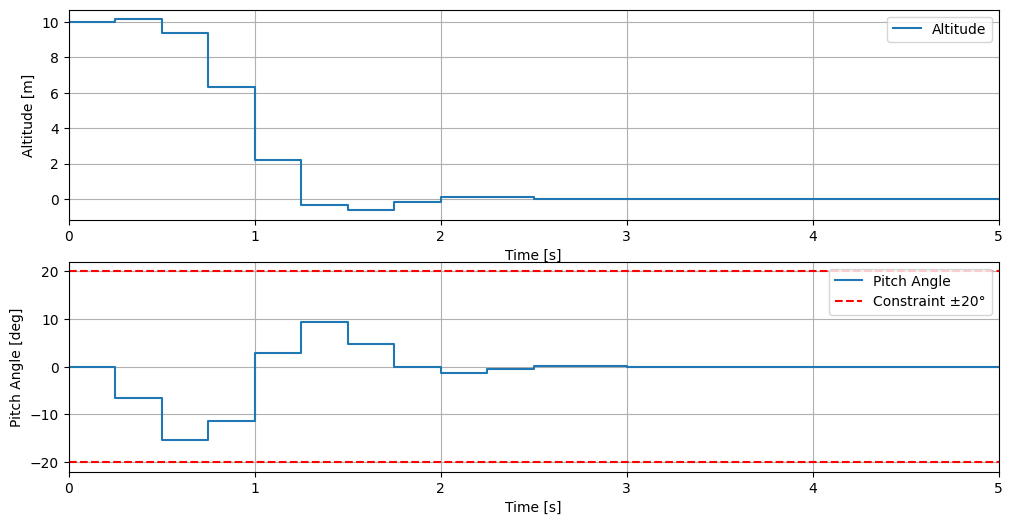

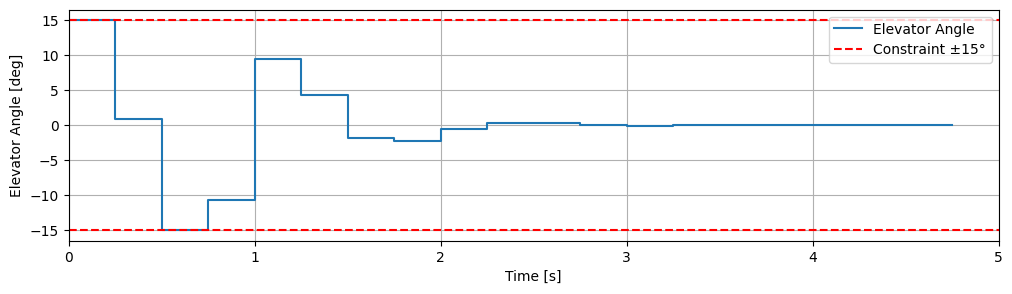

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from openmpc.LinearMPC import MPCParameters, MPC, LinearSystem

# Define the continuous-time state-space model
A_cont = np.array([
    [-1.2822, 0, 0.98, 0],
    [0, 0, 1, 0],
    [-5.4293, 0, -1.8366, 0],
    [-128.2, 128.2, 0, 0]
])
B_cont = np.array([[-0.3], [0], [-17], [0]])
C_cont = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
D_cont = np.zeros((2, 1))

h = 0.25
# Discretize the continuous-time model using zero-order hold
system = LinearSystem.c2d(A_cont, B_cont, C_cont, D_cont, h)

# Define the initial state
x0 = np.array([0, 0, 0, 10])  # Initial state: descent of 10 meters

# Define MPC parameters
Q = np.eye(4)  # State penalty matrix
R = np.array([[10]])  # Input penalty matrix
T = 10  # Prediction horizon

# Create MPC parameters object
mpc_params = MPCParameters(system= system, horizon=T, Q=Q, R=R, QT=np.zeros((4, 4)), solver='MOSEK')

# Add input magnitude constraint (elevator angle limited to ±15°)
mpc_params.add_input_magnitude_constraint(limit=np.deg2rad(15), is_hard=True)

# Add output magnitude constraint on the pitch angle (±20°)
mpc_params.add_output_magnitude_constraint(limit=np.deg2rad(20), output_index=0, is_hard=True)

# Add dual-mode with LQR controller
mpc_params.add_dual_mode(dual_mode_horizon=5)

# Create the MPC object
mpc = MPC(mpc_params)


# Simulation settings
num_steps = 20  # Number of simulation steps to cover 5 seconds
x_sim = np.zeros((4, num_steps + 1))  # Store state trajectory
u_sim = np.zeros(num_steps)  # Store control inputs
x_sim[:, 0] = x0  # Set initial state

# Simulate the system
for t in range(num_steps):
    # Get the current state
    current_state = x_sim[:, t]

    # Compute the control action using MPC
    u_t = mpc.get_control_action(current_state)
    u_sim[t] = u_t  # Store the control input

    # Apply the control input to the discrete-time system
    x_next = system.A @ current_state + system.B @ u_t.flatten()
    x_sim[:, t + 1] = x_next

# Plot the results
time = np.arange(num_steps + 1) * h

# Plot altitude and pitch angle with stairs plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.step(time, x_sim[3, :], where='post', label='Altitude')
plt.xlabel('Time [s]')
plt.ylabel('Altitude [m]')
plt.xlim([0, 5])
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.step(time, np.rad2deg(x_sim[1, :]), where='post', label='Pitch Angle')
plt.axhline(20, color='r', linestyle='--', label='Constraint ±20°')
plt.axhline(-20, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Pitch Angle [deg]')
plt.xlim([0, 5])
plt.legend()
plt.grid()

# Plot the control input with stairs plot
plt.figure(figsize=(12, 3))
plt.step(time[:-1], np.rad2deg(u_sim), where='post', label='Elevator Angle')
plt.axhline(15, color='r', linestyle='--', label='Constraint ±15°')
plt.axhline(-15, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Elevator Angle [deg]')
plt.xlim([0, 5])
plt.legend()
plt.grid()

plt.show()
